In [1]:
from google.colab import drive
drive.mount('/content/drive')

BASE = "/content/drive/MyDrive/A2A_prediction_system"


Mounted at /content/drive


In [2]:
!pip -q install fastapi "uvicorn[standard]" orjson requests \
                 langgraph yfinance numpy pandas scikit-learn ta matplotlib


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.8/510.8 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.2/452.2 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 18.2 MB/s eta 0:00:00


In [3]:
import os, sys, pathlib, importlib, traceback

# package markers
pathlib.Path(f"{BASE}/backend/__init__.py").touch()
pathlib.Path(f"{BASE}/backend/a2a/__init__.py").touch()

# make project importable
if BASE not in sys.path:
    sys.path.insert(0, BASE)


os.environ["A2A_ROOT"] = BASE
os.environ["PYTHONPATH"] = f"{BASE}:{BASE}/backend"

# quick checks
print("Has app.py?    ", os.path.exists(f"{BASE}/backend/app.py"))
print("Has orchestrator?", os.path.exists(f"{BASE}/backend/a2a/orchestrator.py"))
print("Has index.html?", os.path.exists(f"{BASE}/frontend/index.html"))

# import test: should print OK
try:
    importlib.import_module("backend.app")
    print("backend.app import OK")
except Exception:
    print("Import failed:\n", traceback.format_exc())


Has app.py?     True
Has orchestrator? True
Has index.html? True
backend.app import OK


In [4]:
import time, requests

# stop any old server
!pkill -f "uvicorn .* backend.app:app" >/dev/null 2>&1 || true

# start fresh
%cd $BASE
!nohup python -m uvicorn backend.app:app --host 0.0.0.0 --port 8000 --loop asyncio --http h11 > /tmp/uvicorn.log 2>&1 &

# wait
ok = False
for _ in range(20):
    time.sleep(0.5)
    try:
        print("Health:", requests.get("http://127.0.0.1:8000/health", timeout=2).json())
        ok = True
        break
    except: pass

if not ok:
    print("Server not ready. Recent logs:")
    !tail -n 120 /tmp/uvicorn.log
else:
    print("UI status:", requests.get("http://127.0.0.1:8000/ui/index.html", timeout=5).status_code)


^C
/content/drive/MyDrive/A2A_prediction_system
Health: {'ok': True}
UI status: 200


In [5]:
# start a quick tunnel (prints a trycloudflare URL)
!curl -L https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64 -o /usr/local/bin/cloudflared
!chmod +x /usr/local/bin/cloudflared

import subprocess, re, time
proc = subprocess.Popen(
    ["cloudflared","tunnel","--url","http://localhost:8000","--no-autoupdate"],
    stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True
)
BASE_PUBLIC = None
deadline = time.time() + 60
while time.time() < deadline:
    line = proc.stdout.readline()
    if not line: time.sleep(0.1); continue
    m = re.search(r"https://[\w\.-]*trycloudflare\.com", line)
    if m: BASE_PUBLIC = m.group(0); break

print("Public URL:", BASE_PUBLIC)

# open a tab
from google.colab import output
if BASE_PUBLIC:
    output.eval_js(f'window.open("{BASE_PUBLIC}/ui/index.html", "_blank")')
    print("If the tab didn’t open, click:", f"{BASE_PUBLIC}/ui/index.html")


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 39.2M  100 39.2M    0     0  55.0M      0 --:--:-- --:--:-- --:--:--  145M
Public URL: https://asylum-tr-enhancements-comprehensive.trycloudflare.com
If the tab didn’t open, click: https://asylum-tr-enhancements-comprehensive.trycloudflare.com/ui/index.html


In [6]:
# Colab cell
from backend.a2a.orchestrator import run_orchestrator

cfg = {
  "user_request": "Analyze AAPL last 5 years; forecast 3 days; include evaluation, IG and SHAP, risk, optimization, and HTML report.",
  "tickers": ["AAPL"],
  "report_out_name": "llm_report.html",
  "xai_args": {
      "skip_shap": False,

      "k_last": 60, "bg_cap": 48,
      "shap_backend_order": ["gradient","deep"],
      "kernel_nsamples": 80
  }
}

res = run_orchestrator(cfg)
print("Run base:", res["run_base"])
print("Report path:", res["report_path"])



[ENTRY] NL mode
[RECEPTION] ack: Thanks! I’ll analyze AAPL over 2020-09-05 → 2025-09-05, then coordinate data → features → prediction → evaluation → IG & SHAP → risk → optimization, and return a report.
[DataCollector] incoming run_base: None | env RUN_BASE: /content/drive/MyDrive/A2A_prediction_system/RUN_20250905_144238

[DataCollector] Tickers: ['AAPL']
[DataCollector] Window : 2020-09-06 → 2025-09-05
[DataCollector] Output : /content/drive/MyDrive/A2A_prediction_system/RUN_20250905_144238/data/yfinance_raw_data.csv

Downloading: AAPL
  AAPL: 1255 rows ready.

[DataCollector] Saved: /content/drive/MyDrive/A2A_prediction_system/RUN_20250905_144238/data/yfinance_raw_data.csv
[DataCollector] Records: 1255 from 1 ticker(s)
[DataCollector] Columns: ['Date', 'Open', 'Close', 'High', 'Low', 'Volume', 'Symbol']

 Training model for AAPL...
   Sequences - Train: 837, Val: 147, Test: 149
   tried 1/3 -> val_loss=1.163958
   tried 2/3 -> val_loss=1.145024
   tried 3/3 -> val_loss=1.163775
   b

  0%|          | 0/60 [00:00<?, ?it/s]

    AAPL: SHAP completed (head='close')
 Saved summary → /content/drive/MyDrive/A2A_prediction_system/RUN_20250905_144238/Explainability/SHAP_XAI/shap_xai_summary.json
[Explainability] Combined summary → /content/drive/MyDrive/A2A_prediction_system/RUN_20250905_144238/Explainability/explainability_summary.json
 Risk assessment saved → /content/drive/MyDrive/A2A_prediction_system/RUN_20250905_144238/Risk_Assessment
[Opt] Loaded mode=historical, ticker=AAPL, head=close
[Opt] q_abs_ret=0.035832
[Opt] Built weights: 149 rows (nonzero 0)
[Opt] Backtest built: 149 days, equity nan
[Opt] Saved: equity_curve.csv  & summary.json → /content/drive/MyDrive/A2A_prediction_system/RUN_20250905_144238/Opt_results
[Opt] Last: {'timestamp': '2025-09-04 00:00:00', 'weight': 0.0, 'decision': 'FLAT', 'go_nogo': 'NO-GO'}
Summarizer wrote:
  - /content/drive/MyDrive/A2A_prediction_system/RUN_20250905_144238/reports/final_payload.json
  - /content/drive/MyDrive/A2A_prediction_system/RUN_20250905_144238/report

Category,Metric,Value
Prediction Accuracy,R² (price),0.900
Prediction Accuracy,RMSE (price),$4.852
Prediction Accuracy,MAPE,1.49%
Trend Prediction,Directional Accuracy,44.3%
Statistical Insights,Sharpe (annualised),—
Statistical Insights,Max Drawdown,—
Risk Assessment,Label,HIGH
Risk Assessment,SNR (latest),0.08
Risk Assessment,Crosses zero,True
Model Explainability,SHAP status,Shown

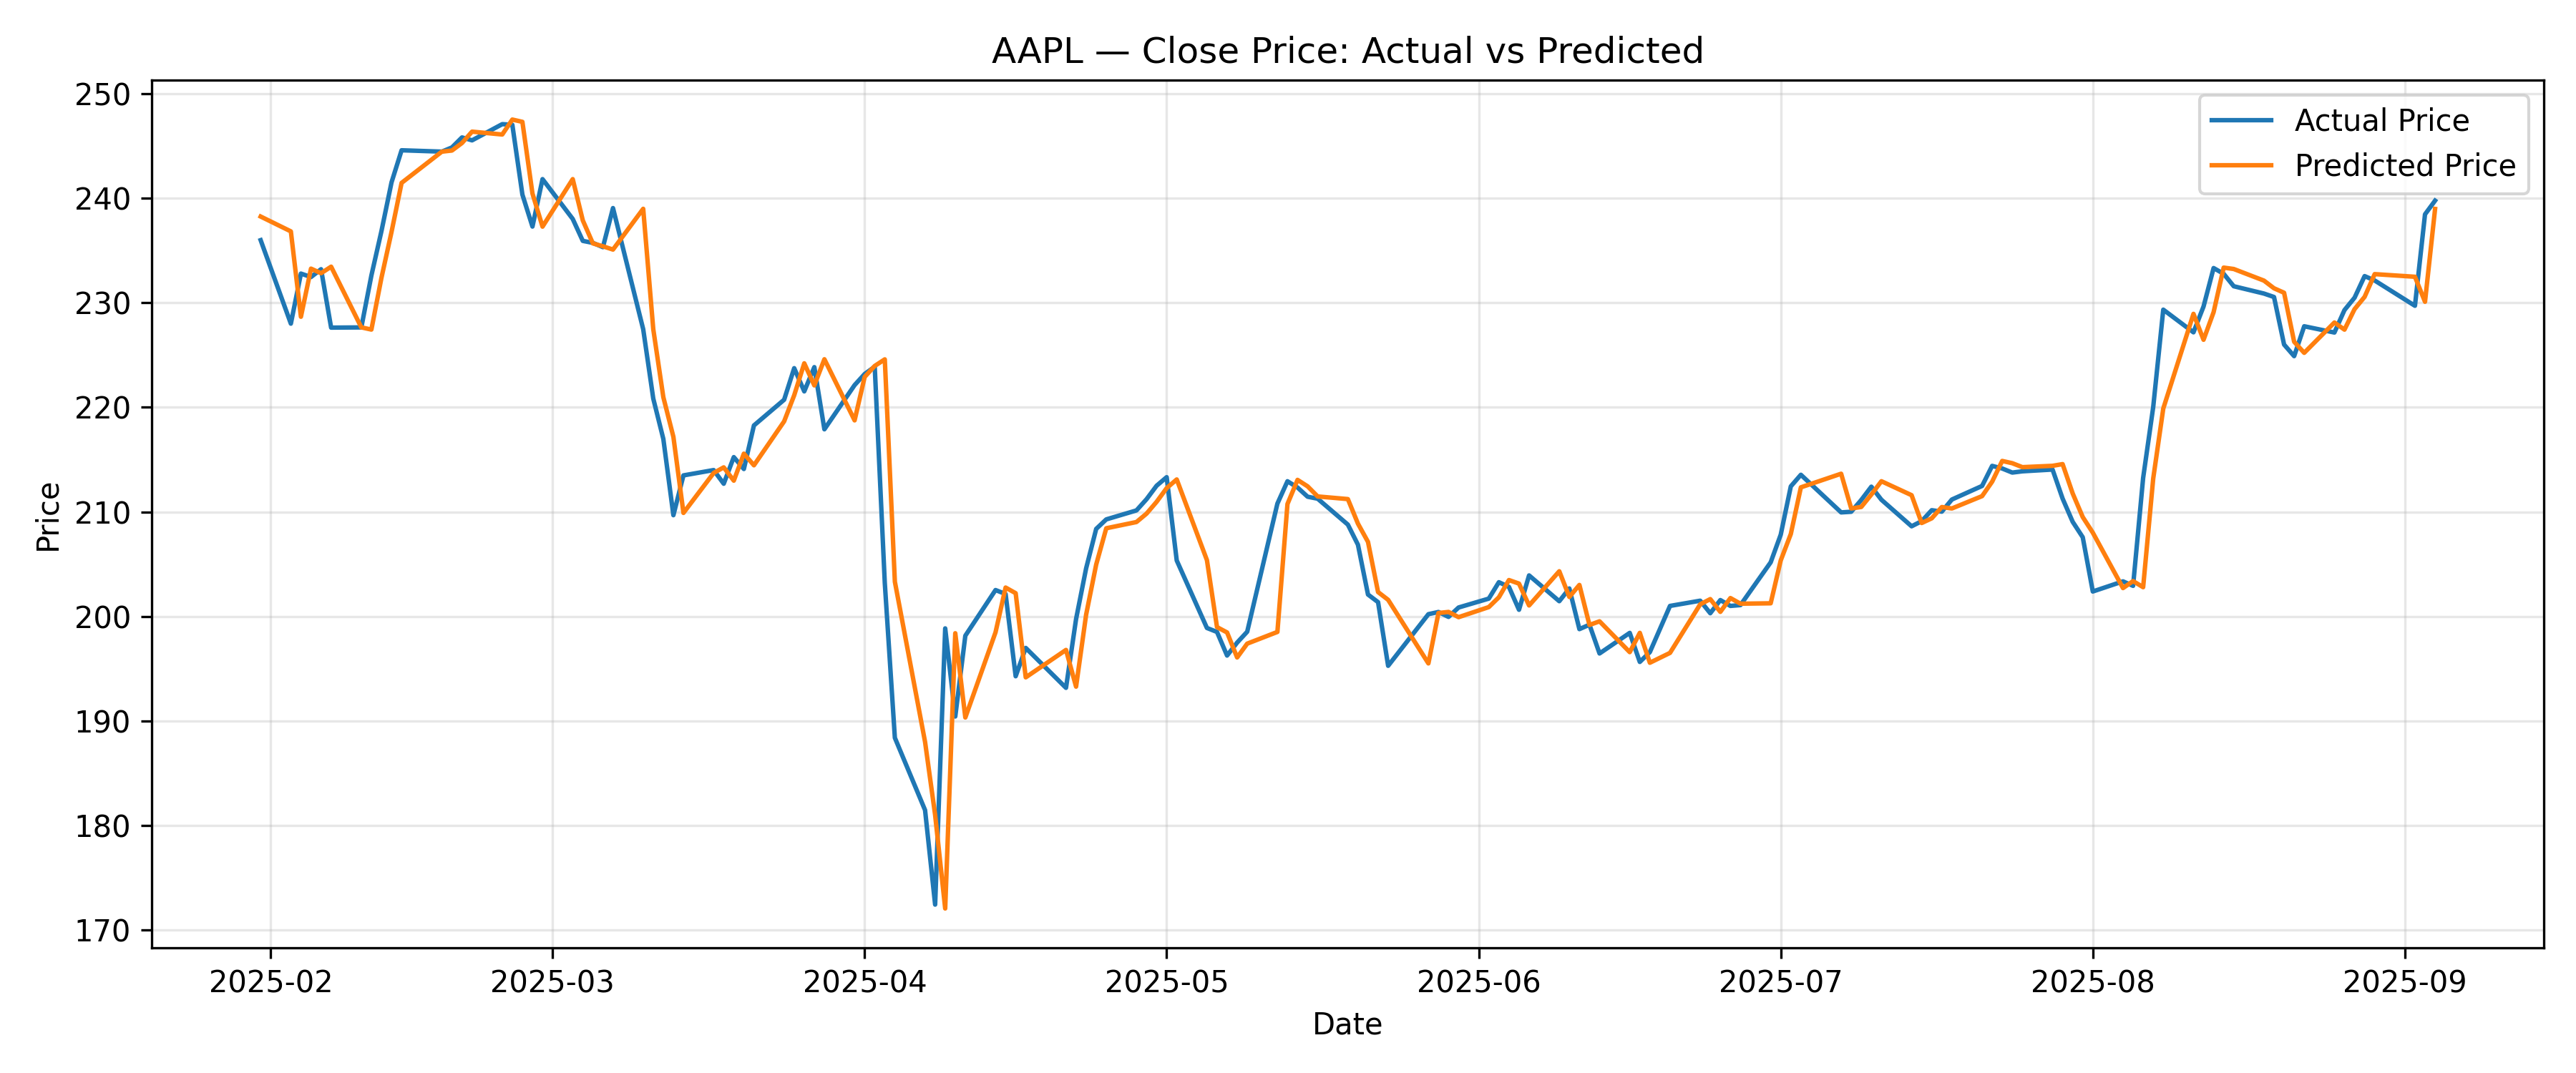
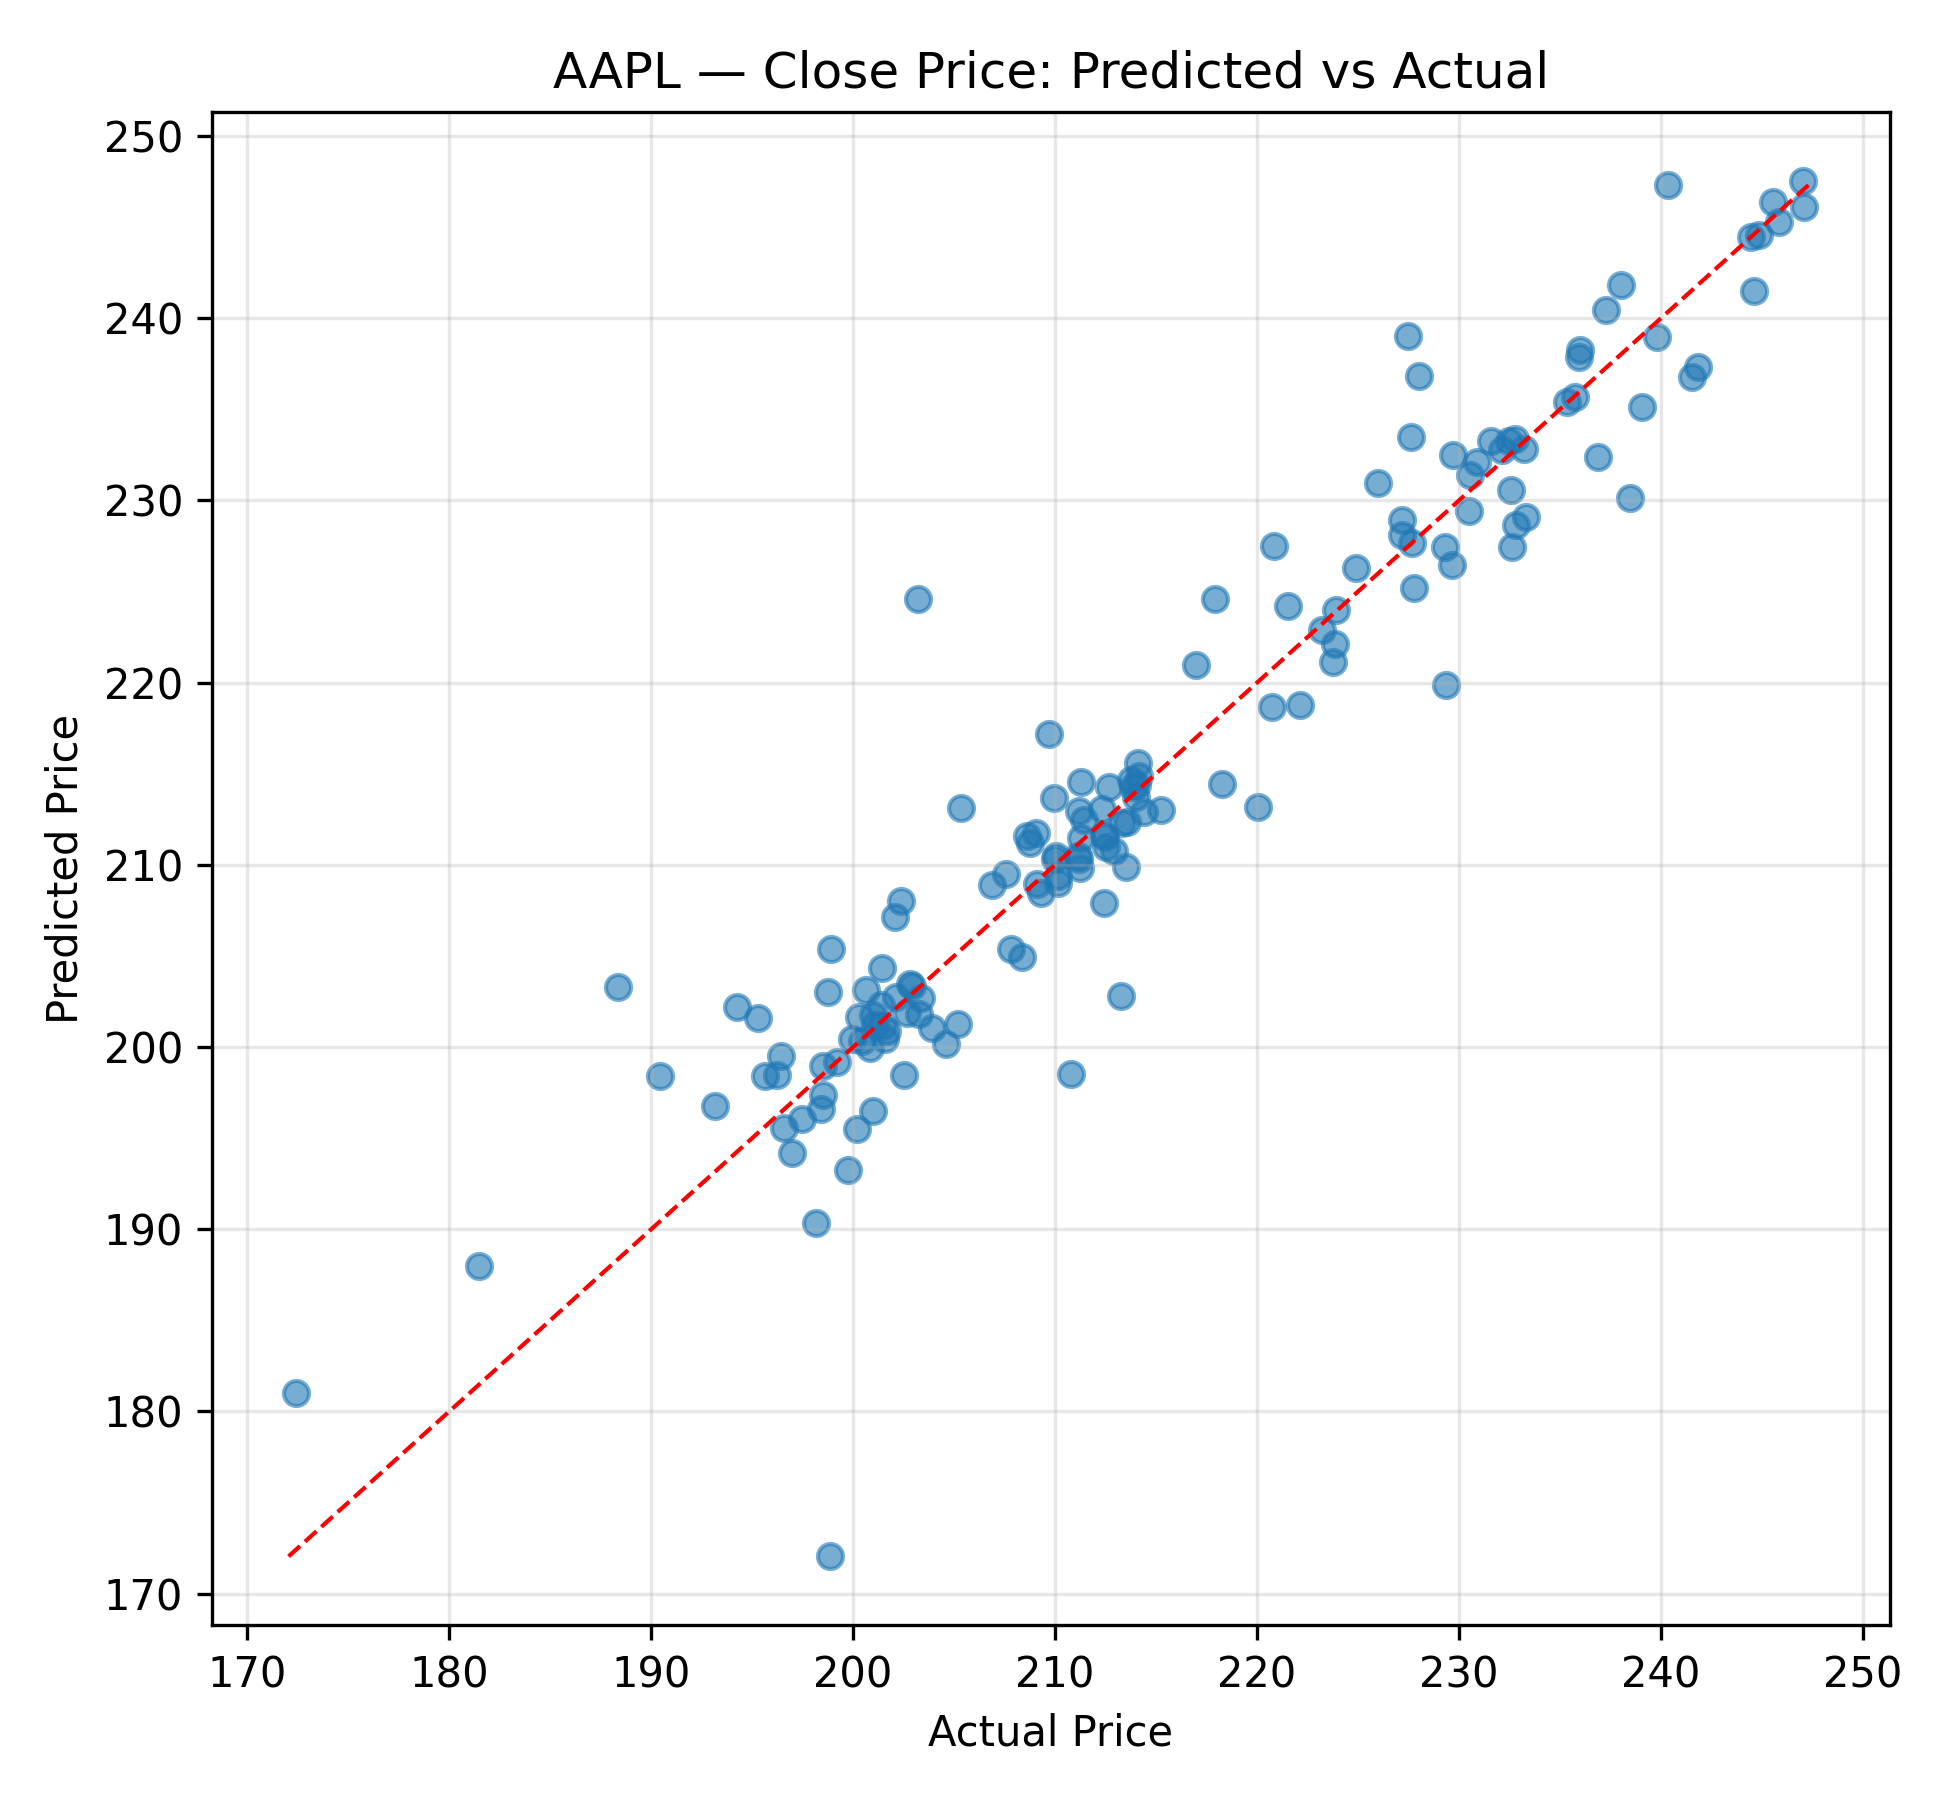
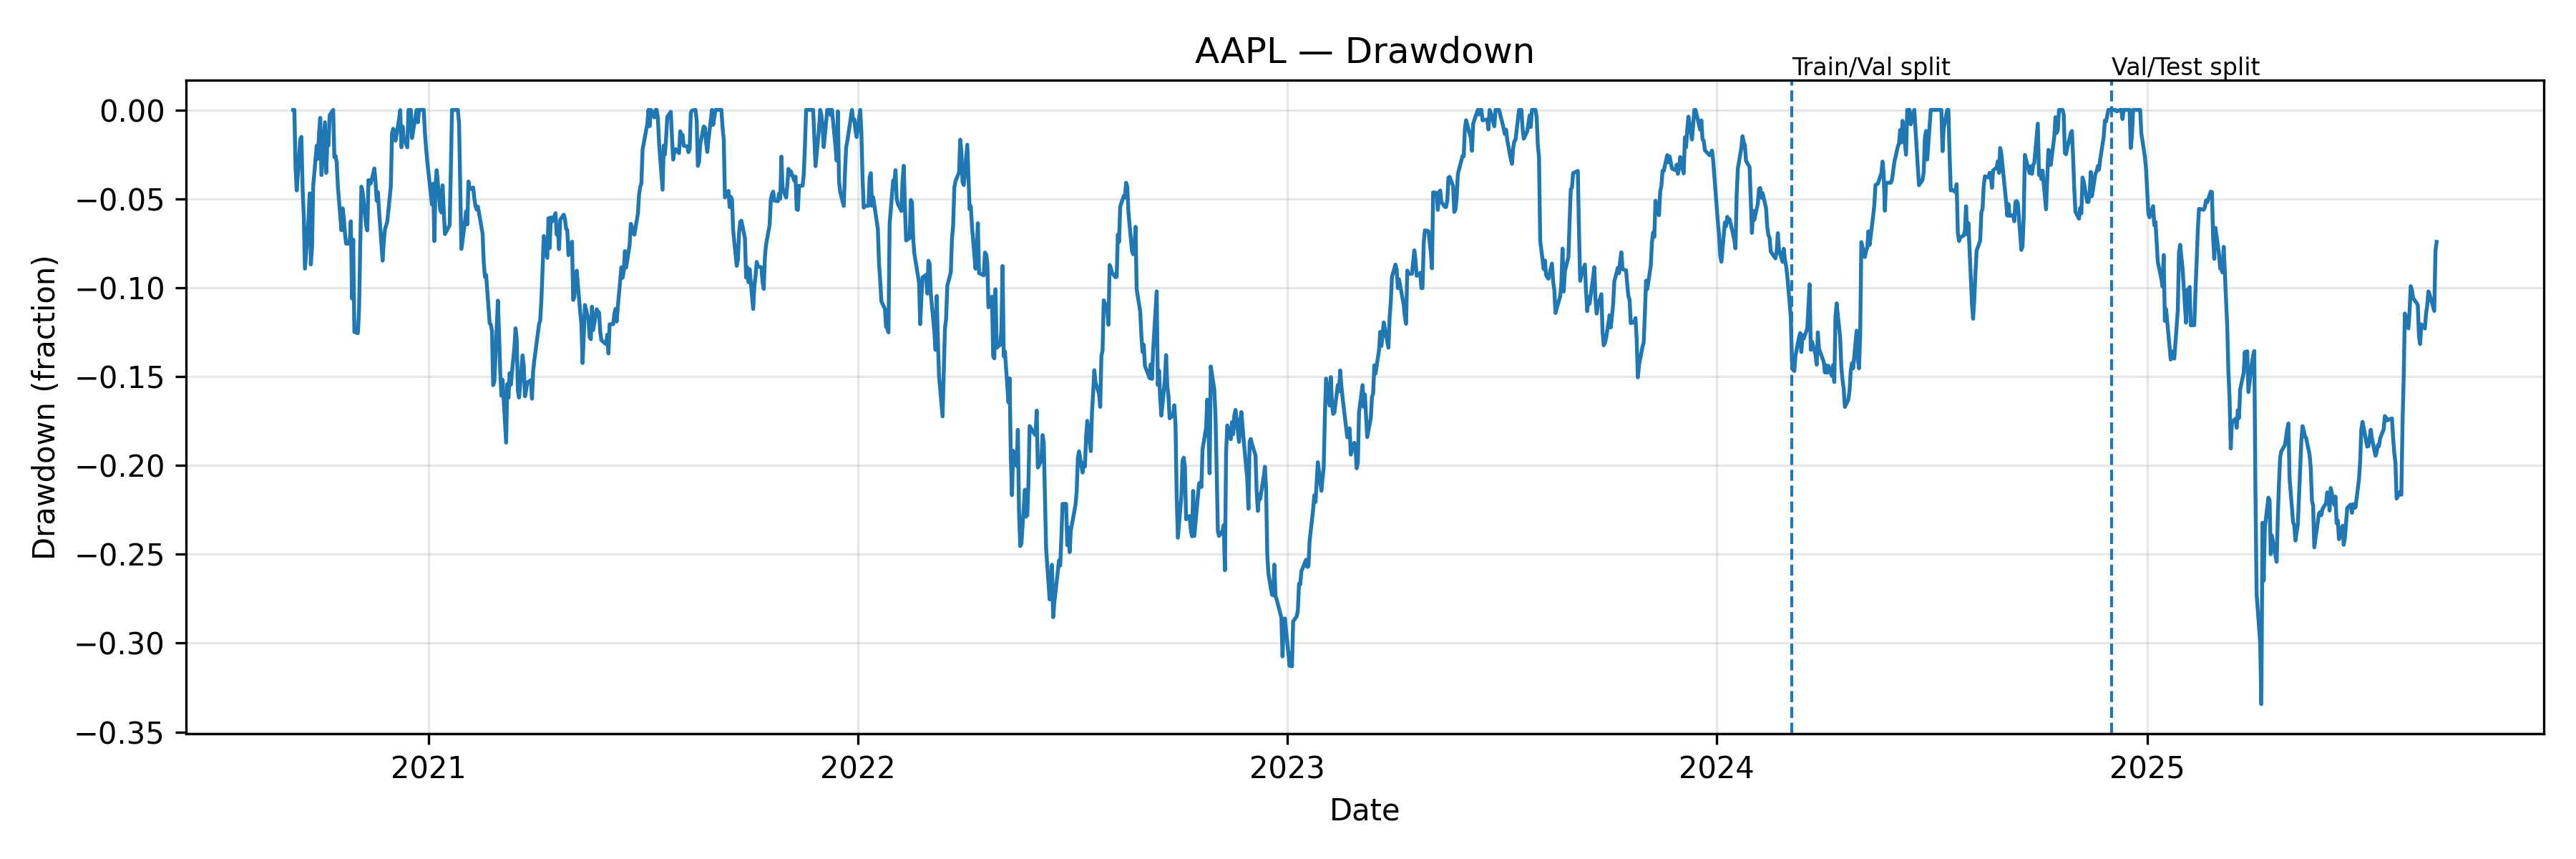
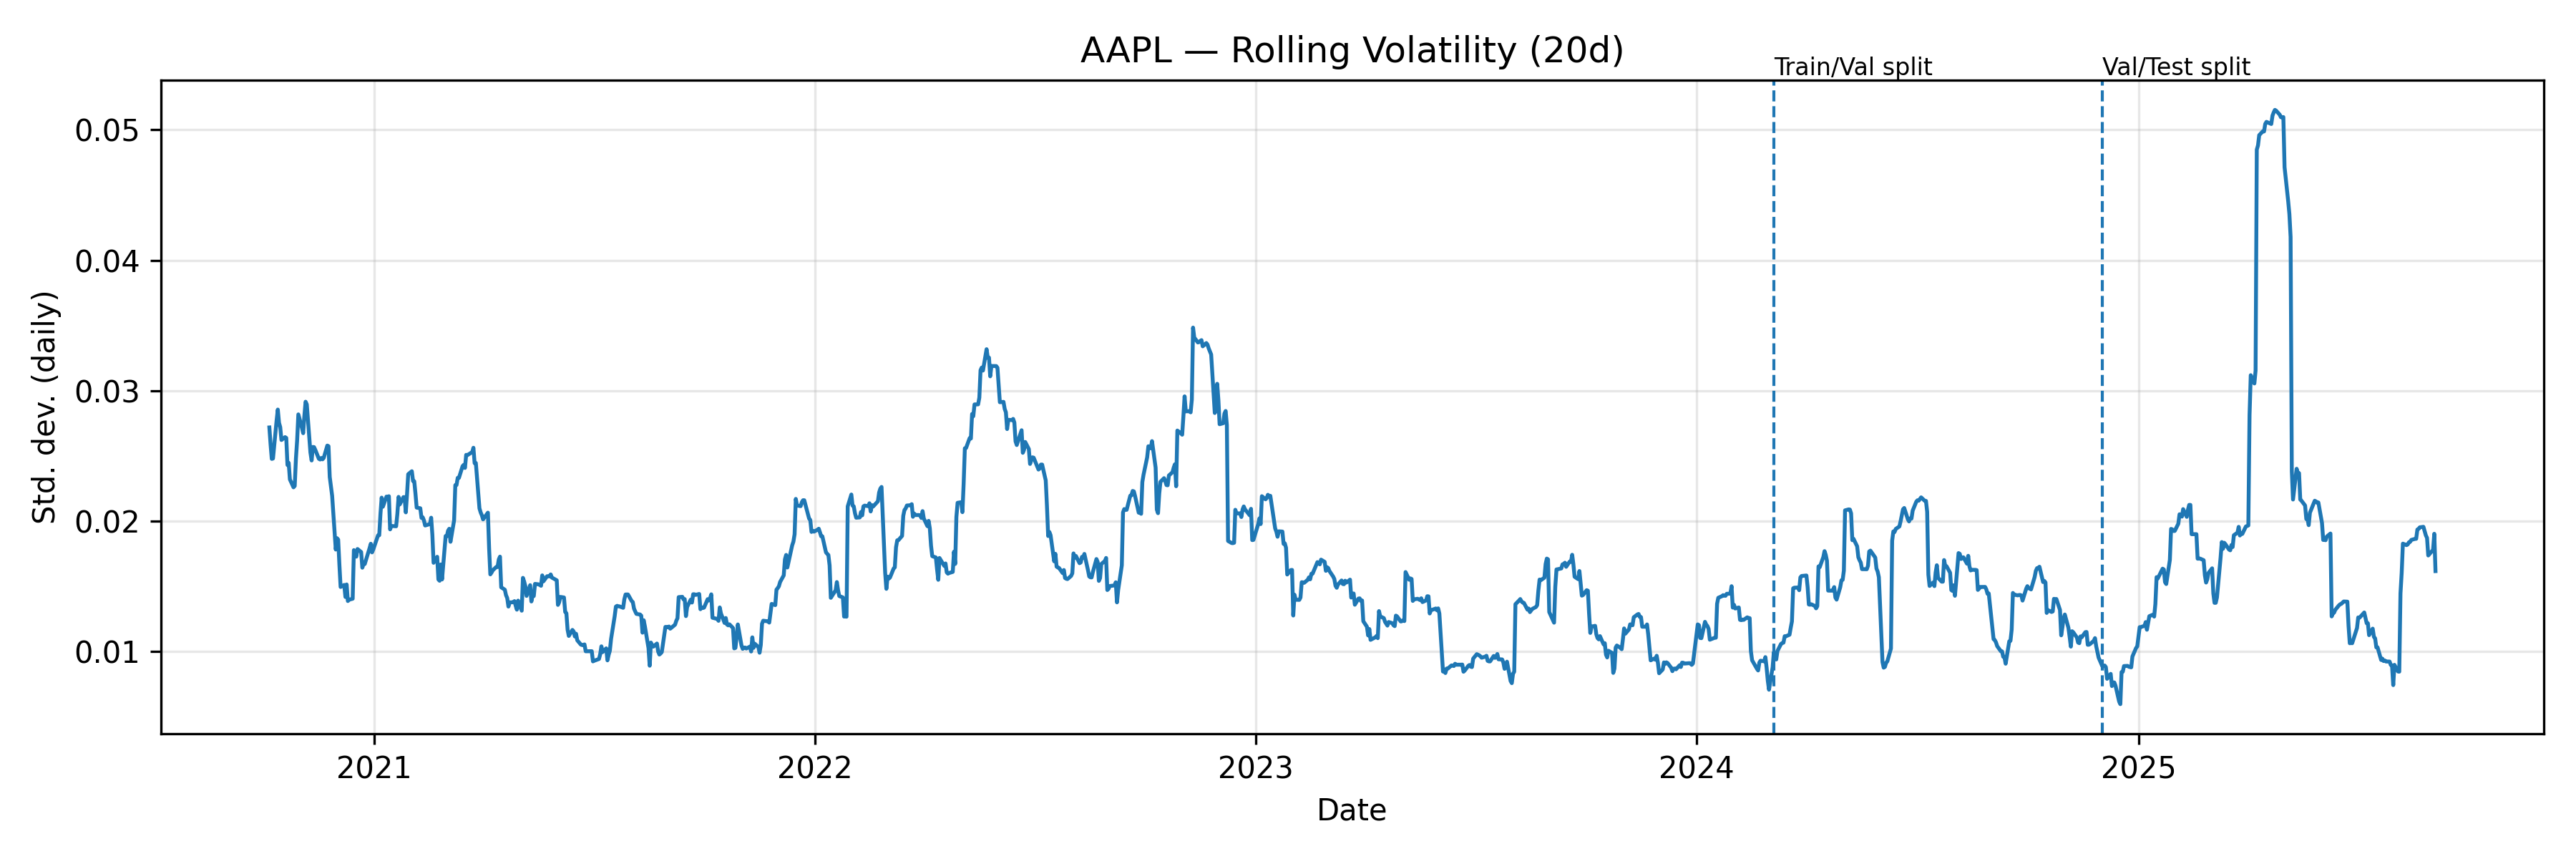
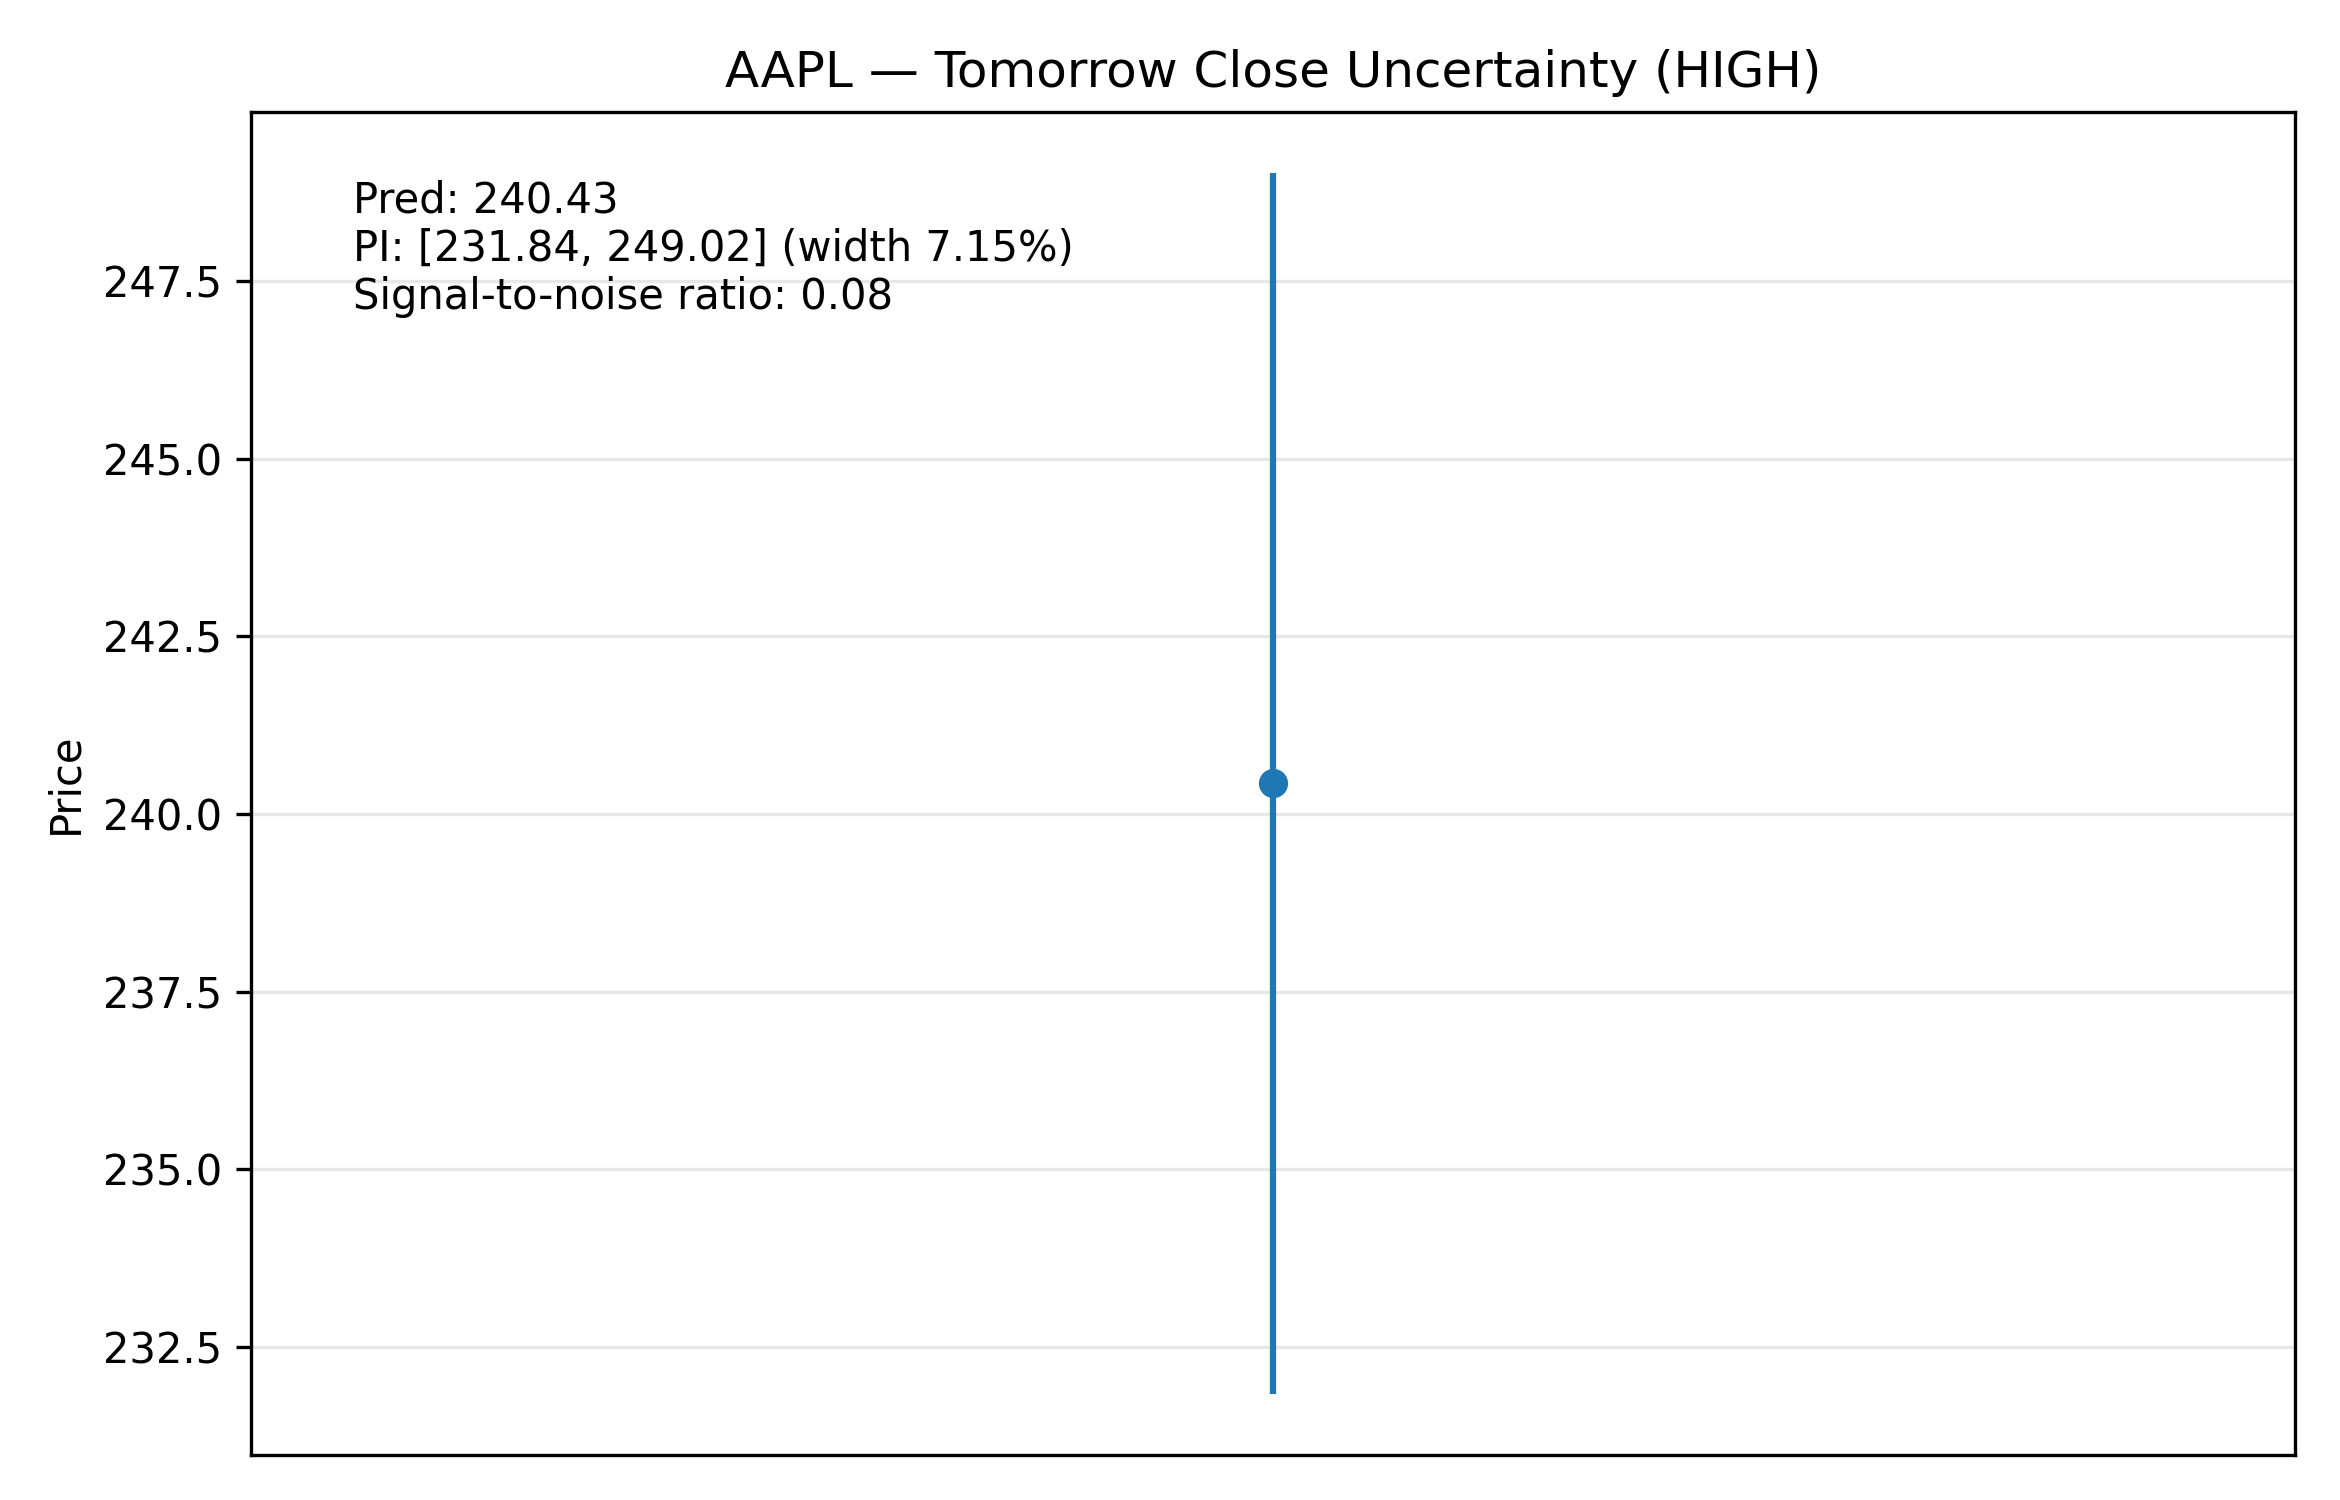
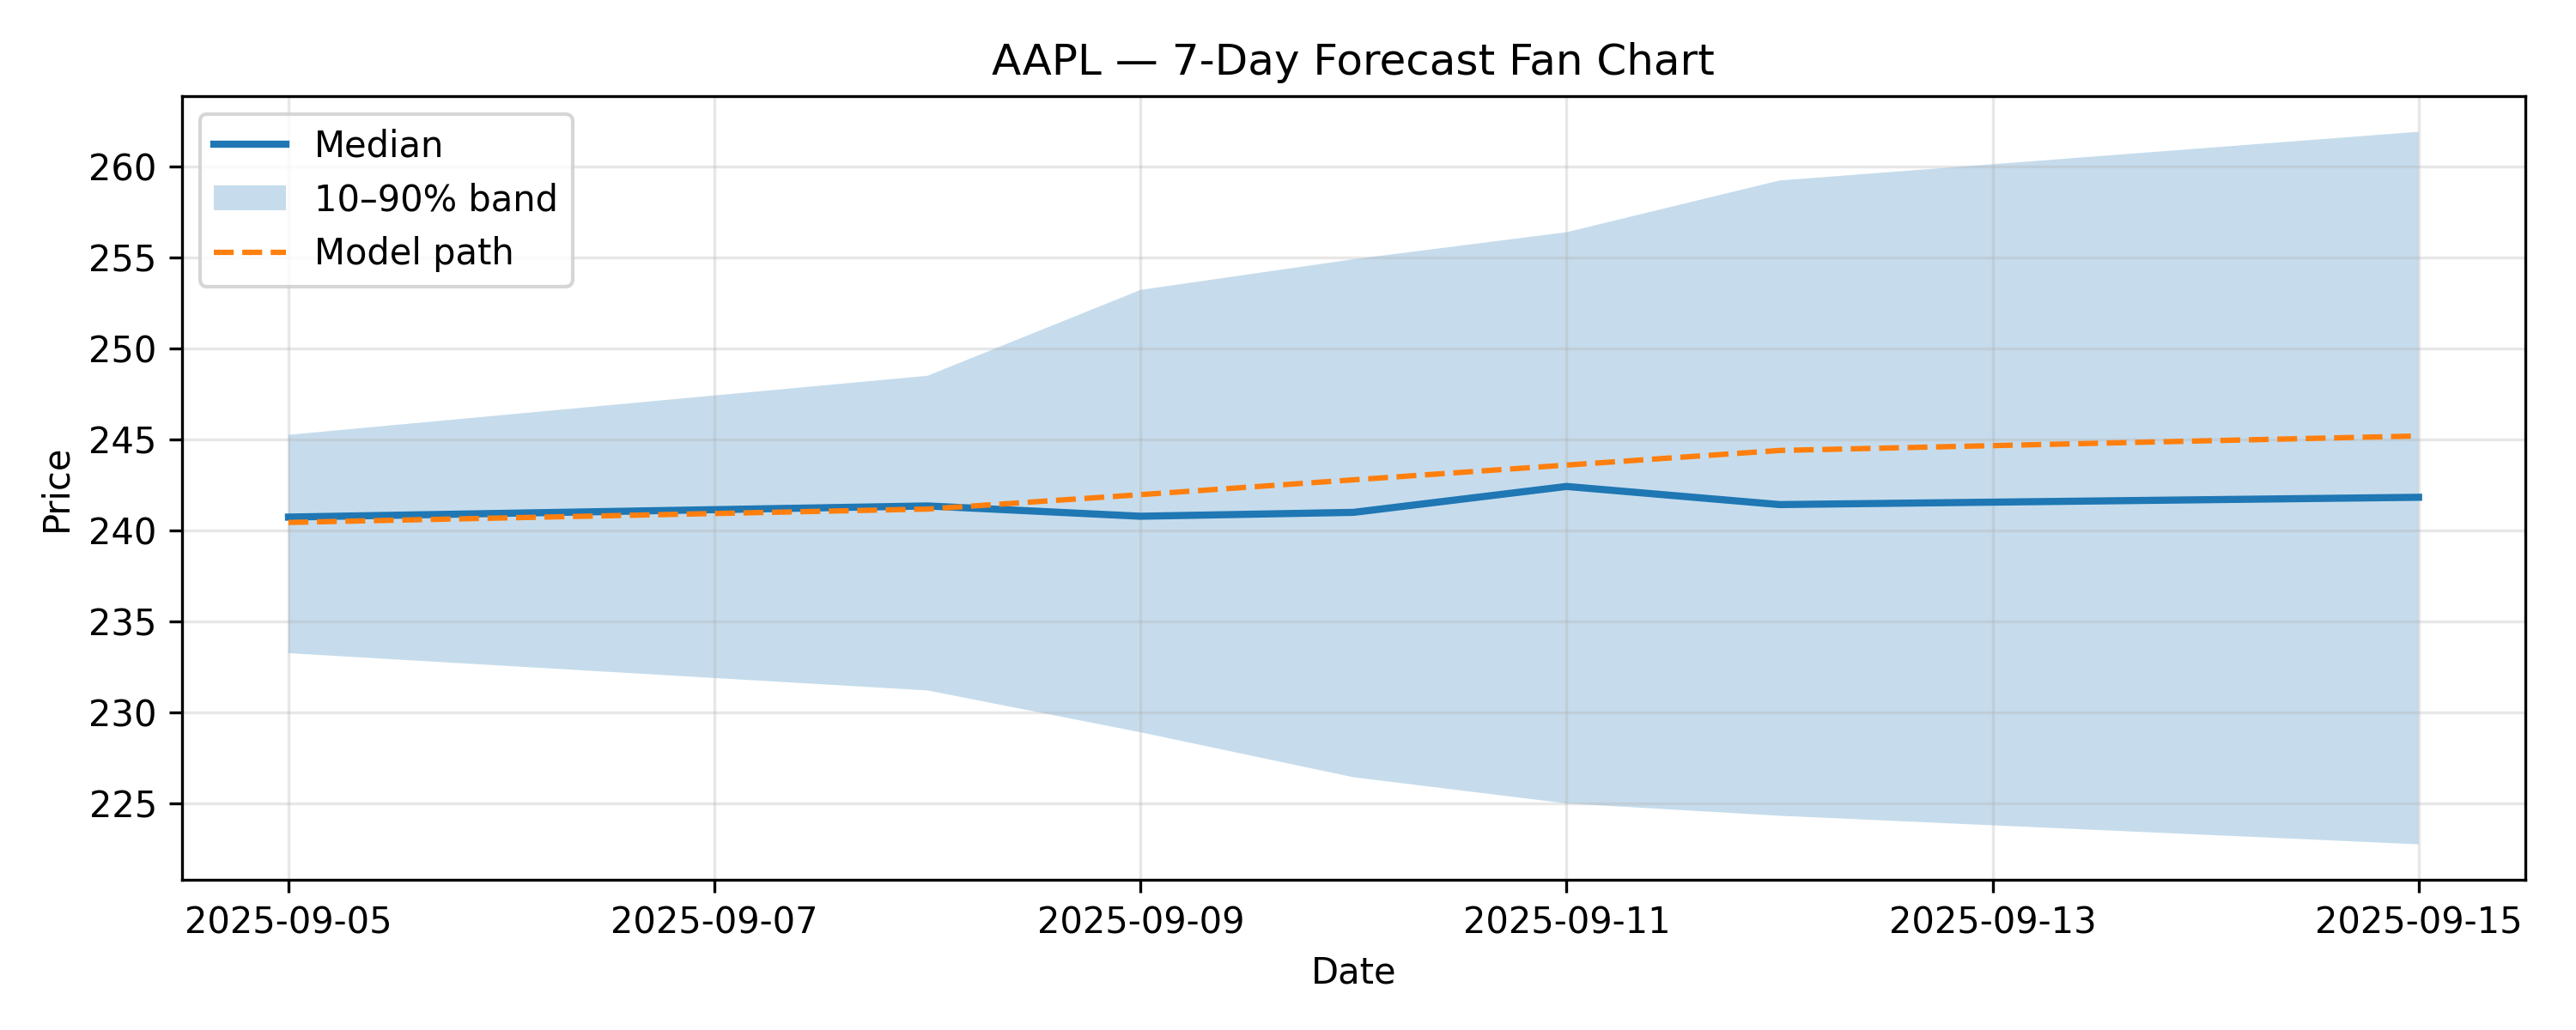
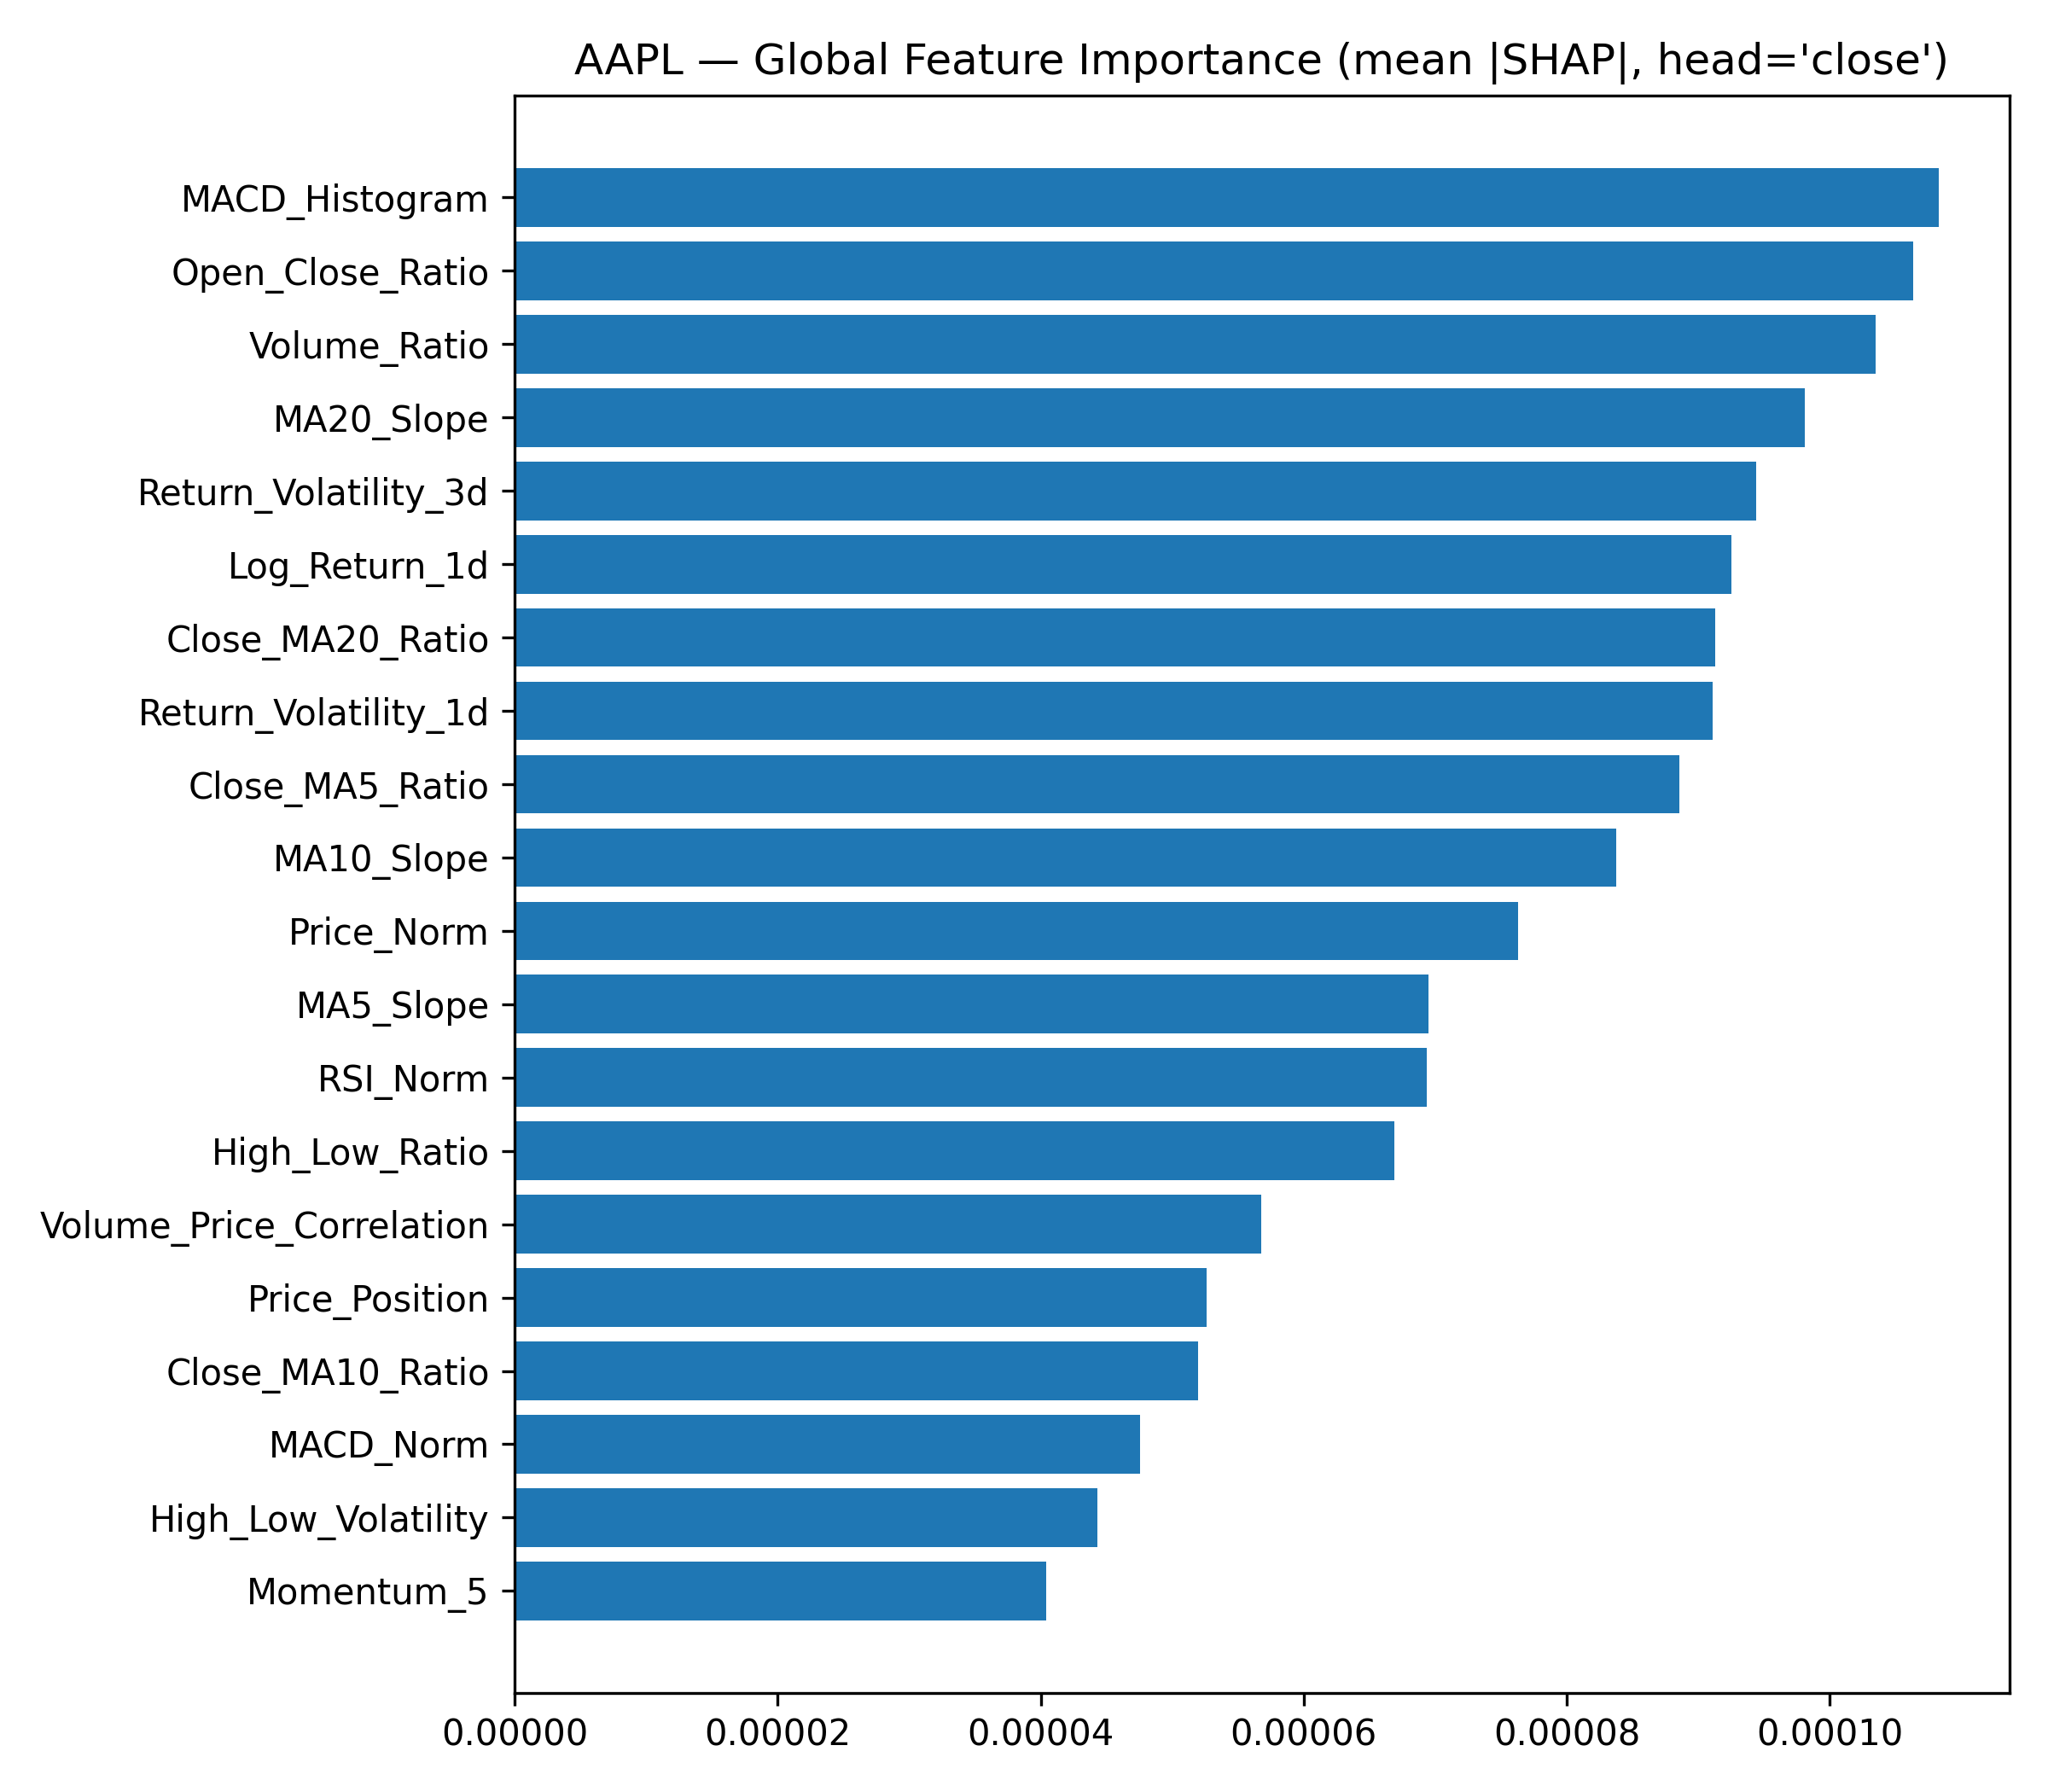
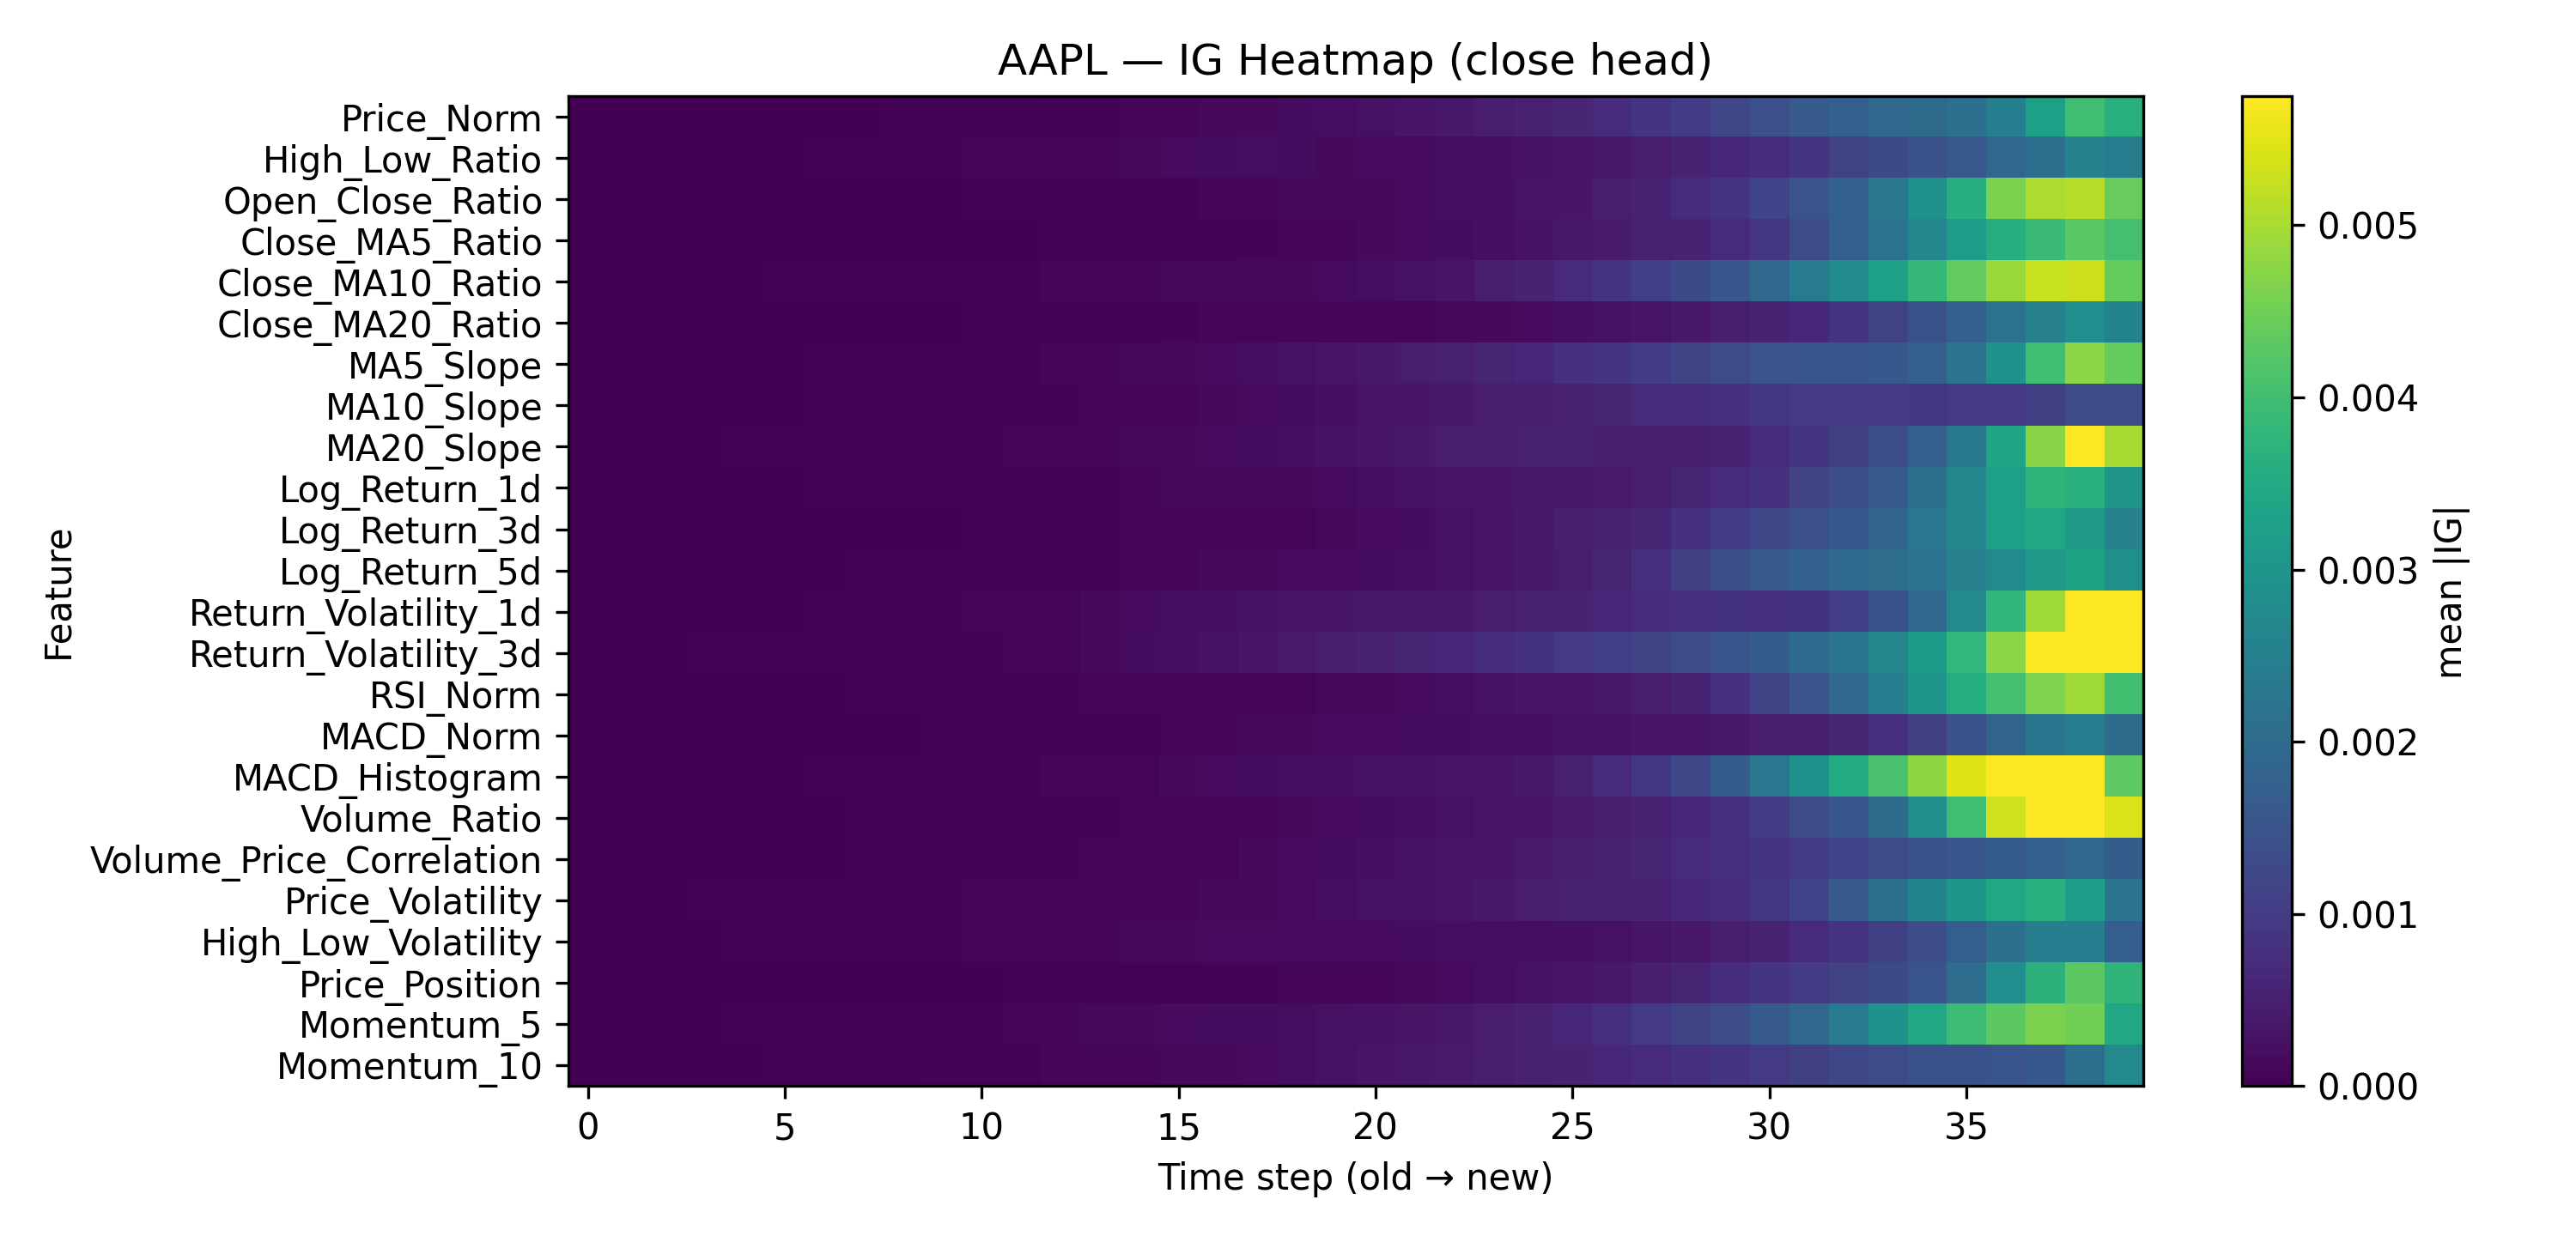

In [7]:
from IPython.display import HTML
# quick preview by rewriting absolute paths if needed
html = open(res["report_path"], "r", encoding="utf-8").read()
HTML(html)
